# Making Hunger Score Predictions
### Approach:
* Models: Lasso, Random Forest Regressor (RF), Support Vector Regression (SVR)
* Perfomr a grid search for 1-month and 3-month predictions of all models
* Used Lasso (and RF) to measure feature importance  

### Results:
* Lasso: An empty model — ie all coefficients converged to zero.
* RF: Battle count was the only feature used to only slightly improve upon a baseline prediction of the sample average hunger score.
* SVR: Performed far worse than the baseline prediction by sample average. Possibly due to skewed data.

## 1 Load and Clean Data
* load and drop redundant columns
* NaNs of event data should be converted to 0s
* make Admin1 names unique

In [1]:
import pandas as pd
import pipeline
import importlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [41]:
import warnings
warnings.filterwarnings(action='once')

In [69]:
# for reloading the pipeline if neccesary...
importlib.reload(pipeline)

<module 'pipeline' from '/Users/matthewmauer/ML/project/pipeline.py'>

In [7]:
data = pipeline.read('create_targets/total_data_with_targets.csv')
data.sample(5)

There are 14068 rows and 24 columns in the data set.


,ADMIN0,ADMIN1,month,year,CS,tmin_mm,tmax_mm,tavg_mm,prcp_mm,battle_cnt,...,battle_fatal,protest_fatal,riot_fatal,explosion_fatal,violence_on_civs_fatal,Retail,pop,CS_in_1_month,CS_in_2_months,CS_in_3_months
8964,Sudan,Blue Nile,4.0,2010.0,1.5,252.000000,430.250000,350.421053,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.739706,922000.0,NaN,NaN,2.0
10510,Sudan,Sinnar,11.0,2011.0,NaN,155.500000,357.657143,253.035714,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1505000.0,NaN,1.500000,NaN
12102,Tanzania,Mwanza,5.0,2011.0,NaN,185.347826,286.954545,235.333333,56.916667,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,2927000.0,NaN,NaN,NaN
10964,Sudan,West Darfur,8.0,2015.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.037245,1634000.0,NaN,1.666667,NaN
1283,Kenya,Bomet,1.0,2015.0,1.5,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,724186.0,NaN,NaN,1.0


In [8]:
data = pipeline.clean_events(data)

In [9]:
data.sample(2)

,ADMIN0,ADMIN1,month,year,CS,tmin_mm,tmax_mm,tavg_mm,prcp_mm,battle_cnt,...,battle_fatal,protest_fatal,riot_fatal,explosion_fatal,violence_on_civs_fatal,Retail,pop,CS_in_1_month,CS_in_2_months,CS_in_3_months
8506,South Sudan,Upper Nile,4.0,2014.0,2.4,NaN,NaN,NaN,NaN,21.0,...,56.0,0.0,0.0,0.0,0.0,NaN,1346000.0,NaN,NaN,2.4
6199,Somalia,Gedo,8.0,2011.0,NaN,NaN,NaN,NaN,NaN,10.0,...,24.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,4.0,NaN


In [26]:
data = pipeline.unique_regions(data)

## 2.1 LASSO Regression for 3-month Predictions
* perform a small grid search tuning the alpha from the loss function
* use group k-fold cross validation to prevent data leakage
* discover feature importance

In [15]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [38]:
features = ['tmin_mm', 'tmax_mm', 'tavg_mm', 'prcp_mm',
       'battle_cnt', 'protest_cnt', 'riot_cnt', 'explosion_cnt',
       'violence_on_civs_cnt', 'battle_fatal', 'protest_fatal',
       'riot_fatal', 'explosion_fatal', 'violence_on_civs_fatal',
       'Retail', 'pop']

Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_3_months',
                                                       grouping='ADMIN1')

In [39]:
lasso_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('lasso', Lasso())
])

params = {
    'lasso__alpha': (0.01, 0.1, 1, 10, 100) 
} 

scores = {
          'mse': make_scorer(mean_squared_error),
          'mae': make_scorer(mean_absolute_error),
         }

gcv = GroupKFold()

lasso_grid_model = GridSearchCV(estimator=lasso_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='mse',
                          iid=True)

lasso_grid_results = lasso_grid_model.fit(Xtrain, Ytrain, groups=groups)

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [40]:
lasso_scores = pd.DataFrame(lasso_grid_results.cv_results_)
results = lasso_scores[['param_lasso__alpha', 'mean_test_mse', 'mean_test_mae']]
results

,param_lasso__alpha,mean_test_mse,mean_test_mae
0,0.01,0.390199,0.502830
1,0.1,0.383287,0.500304
2,1,0.392533,0.506669
3,10,0.392533,0.506669
4,100,0.392533,0.506669


In [50]:
best_lasso = lasso_grid_results.best_estimator_
pipeline.model_eval(best_lasso, Xtest, Ytest)


        MSE: 0.3192245273316907
        MAE: 0.48551725449232375
        For a target variable with Standar Deviation: 0.5516070453911287
        


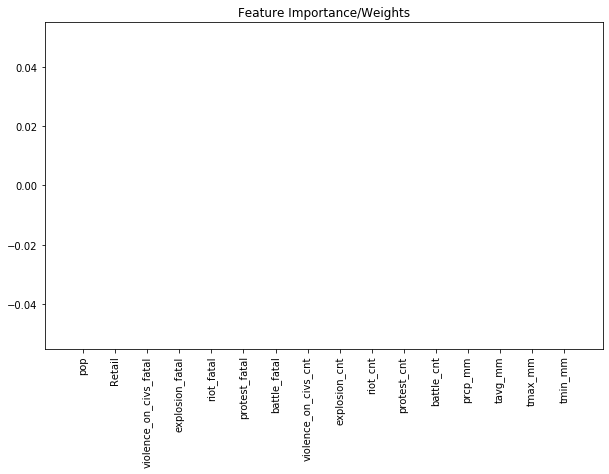

In [54]:
pipeline.feature_importance(best_lasso['lasso'],
                            labels=Xtrain.columns.values)

### Results
Even after normalizing, we have essentially an empty model.

## 2.2 LASSO Regression for 1-month Predictions
Repeat the above process.

In [55]:
Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_1_month',
                                                       grouping='ADMIN1')

lasso2_grid_model = GridSearchCV(estimator=lasso_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='mse',
                          iid=True)

lasso2_grid_results = lasso2_grid_model.fit(Xtrain, Ytrain, groups=groups)

lasso2_scores = pd.DataFrame(lasso2_grid_results.cv_results_)
results2 = lasso2_scores[['param_lasso__alpha', 'mean_test_mse', 'mean_test_mae']]
results2

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


,param_lasso__alpha,mean_test_mse,mean_test_mae
0,0.01,0.386488,0.488189
1,0.1,0.397562,0.494604
2,1,0.402372,0.498083
3,10,0.402372,0.498083
4,100,0.402372,0.498083


In [57]:
best_lasso2 = lasso2_grid_results.best_estimator_
pipeline.model_eval(best_lasso2, Xtest, Ytest)


        MSE: 0.3161452279542899
        MAE: 0.4683750070010606
        For a target variable with Standard Deviation: 0.5622118107922547
        


## Results
Again, we have an empty model.

## 3.1 Random Forest Regressor for 3-month Predictions

In [65]:
Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_3_months',
                                                       grouping='ADMIN1')

forest_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('forest', RandomForestRegressor(random_state=30254))
])

params = {
    'forest__max_depth': (1, 3, 10), 
    'forest__n_estimators': (5, 25, 100)
}

scores = {
          'mse': make_scorer(mean_squared_error),
          'mae': make_scorer(mean_absolute_error),
         }

gcv = GroupKFold()

forest_grid_model = GridSearchCV(estimator=forest_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='mse',
                          iid=True)

forest_grid_results = forest_grid_model.fit(Xtrain, Ytrain, groups=groups)

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [66]:
forest_scores = pd.DataFrame(forest_grid_results.cv_results_)
results = forest_scores[['param_forest__max_depth', 
                         'param_forest__n_estimators',
                        'mean_test_mse', 'mean_test_mae']]
results

,param_forest__max_depth,param_forest__n_estimators,mean_test_mse,mean_test_mae
0,1,5,0.350432,0.470790
1,1,25,0.350432,0.471258
2,1,100,0.350519,0.471096
3,3,5,0.336837,0.453113
4,3,25,0.333115,0.450266
5,3,100,0.331290,0.448282
6,10,5,0.343840,0.451421
7,10,25,0.327787,0.442506
8,10,100,0.324042,0.439449


In [70]:
best_forest = forest_grid_results.best_estimator_
pipeline.model_eval(best_forest, Xtest, Ytest)


        MSE: 0.3003485081626862
        MAE: 0.46859682681106646
        For a target variable with Variance: 0.30427033252513075
        


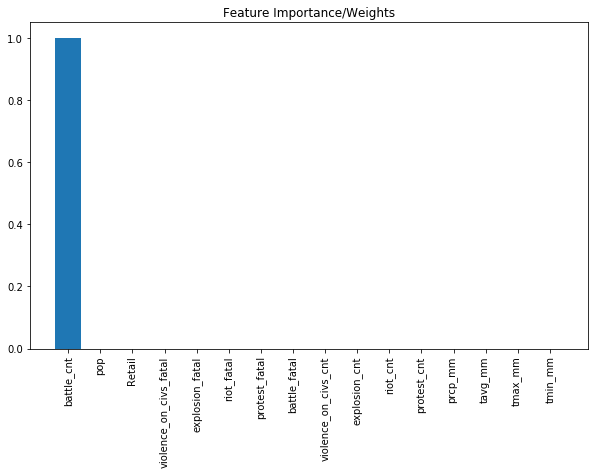

In [68]:
pipeline.feature_importance(best_forest['forest'],
                            labels=Xtrain.columns.values,
                            type='tree')

## 3.2 Random Forest Regressor for 1-month Predictions

In [71]:
Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_1_month',
                                                       grouping='ADMIN1')

forest2_grid_results = forest_grid_model.fit(Xtrain, Ytrain, groups=groups)

pd.DataFrame(forest2_grid_results.cv_results_)[['param_forest__max_depth', 
                                               'param_forest__n_estimators',
                                               'mean_test_mse', 'mean_test_mae']]

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


,param_forest__max_depth,param_forest__n_estimators,mean_test_mse,mean_test_mae
0,1,5,0.361838,0.475267
1,1,25,0.363675,0.477133
2,1,100,0.364180,0.478484
3,3,5,0.347303,0.454450
4,3,25,0.339393,0.448243
5,3,100,0.339293,0.450088
6,10,5,0.330473,0.447739
7,10,25,0.308212,0.430331
8,10,100,0.306918,0.429918


In [72]:
best_forest2 = forest2_grid_results.best_estimator_
pipeline.model_eval(best_forest2, Xtest, Ytest)


        MSE: 0.2833771722145417
        MAE: 0.4513196483371268
        For a target variable with Variance: 0.316082120194306
        


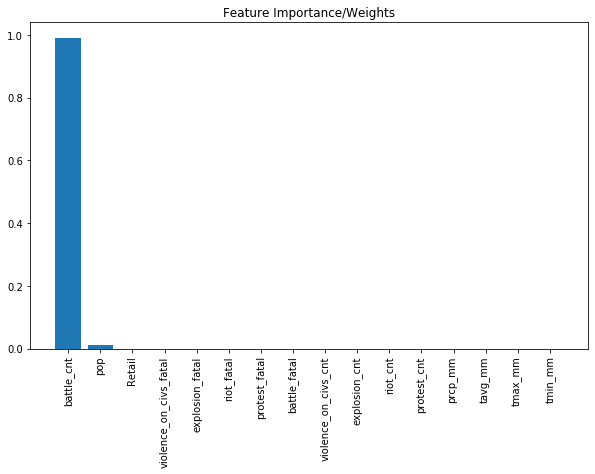

In [73]:
pipeline.feature_importance(best_forest2['forest'],
                            labels=Xtrain.columns.values,
                            type='tree')

## 4 Support Vector Regressor for 3-month Predictions

In [74]:
from sklearn.svm import SVR

In [76]:
Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_1_month',
                                                       grouping='ADMIN1')

svr_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('svr', SVR())
])

params = {
    'svr__kernel': ('poly', 'rbf'),
    'svr__C': (0.1, 1, 10),
    'svr__degree': (2,)
    
} 

scores = {
          'mse': make_scorer(mean_squared_error),
          'mae': make_scorer(mean_absolute_error),
         }

svr_grid_model = GridSearchCV(estimator=svr_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='mse',
                          iid=True)

svr_grid_results = svr_grid_model.fit(Xtrain, Ytrain, groups=groups)

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [78]:
pd.DataFrame(svr_grid_results.cv_results_)[['param_svr__kernel', 'param_svr__C',
                                               'mean_test_mse', 'mean_test_mae']]

,param_svr__kernel,param_svr__C,mean_test_mse,mean_test_mae
0,poly,0.1,4.153146,0.535242
1,rbf,0.1,0.325606,0.434120
2,poly,1,15.052615,0.623711
3,rbf,1,0.329774,0.435621
4,poly,10,27.830619,0.710957
5,rbf,10,0.422064,0.473430


In [79]:
best_svr = svr_grid_results.best_estimator_
pipeline.model_eval(best_svr, Xtest, Ytest)


        MSE: 2.601444825147343
        MAE: 0.6139182581473235
        For a target variable with Variance: 0.316082120194306
        
